# Imports and stuff

In [1]:
import pandas as pd

In [2]:
BATCH_SIZES = ["16", "32", "64", "128", "256", "512", "1024", "2048", "4096"]

In [3]:
def load_medians(fname):
    return pd.read_csv(fname).set_axis(BATCH_SIZES, axis='columns').median()

# Performance Report

Here we compare the performance values.
Note that all values are based on the server readings unless specified otherwise.
Some reading keys:

Key  | Meaning
-----|--------
FP32 | Floating point values
x86  | x86 quantization scheme
SHIR | SHIR quantization scheme
Eager | Eager mode
FX | Interpreting the FX graph (captured by torchdynamo)
Inductor | Compiled with the inductor backend (execute on CPU)
FPGA | Compiled with the SHIR backend (execute on FPGA)


## SLP

### TL;DR

In [4]:
df_slp_summary = pd.DataFrame({
    'SHIR FPGA': load_medians('server_metrics/simple_slp/shir_fpga_2024_02_18.csv'),
    'x86 inductor': load_medians('server_metrics/simple_slp/x86_mixed_inductor.csv'),
    'FP32 eager': load_medians('server_metrics_old/simple_slp/fp32_eager.csv'),
})

df_slp_summary

,SHIR FPGA,x86 inductor,FP32 eager
16,199118.0,145919.5,29451.0
32,240224.5,195786.0,35284.5
64,297341.5,217607.0,57905.0
128,351969.0,279081.0,67106.5
256,481269.0,241879.5,96869.5
512,723416.0,254408.0,120976.5
1024,1379879.0,322900.0,183871.0
2048,2374874.5,477449.5,325168.5
4096,4463980.0,715249.5,515570.0


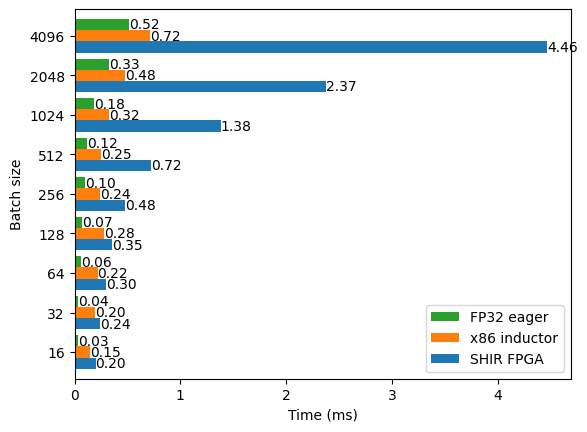

In [14]:
ax = (df_slp_summary / 1_000_000).plot.barh(width=0.85)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Batch size')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

### SHIR Backend on FPGA

In [15]:
df_slp_fpga = pd.DataFrame({
    'SHIR FPGA (pre-2024)': load_medians('server_metrics_old/simple_slp/shir_fpga_buf.csv'),
    'SHIR FPGA (pre-2024 unbuffered)': load_medians('server_metrics_old/simple_slp/shir_fpga_nobuf.csv'),
    'SHIR FPGA (pre-2024 with weight-copy)': load_medians('server_metrics_old/simple_slp/shir_fpga_buf_jit.csv'),
})

df_slp_fpga

,SHIR FPGA (pre-2024),SHIR FPGA (pre-2024 unbuffered),SHIR FPGA (pre-2024 with weight-copy)
16,187292.0,265355.5,189518.5
32,213492.0,372216.5,216211.5
64,261894.5,553933.0,268192.0
128,294456.5,897898.5,300481.5
256,378453.0,1702288.0,377385.0
512,548730.5,3175819.5,548130.0
1024,992051.0,5924658.5,950224.5
2048,1671808.5,11460075.0,1742822.0
4096,3251889.5,24423820.0,3264091.0


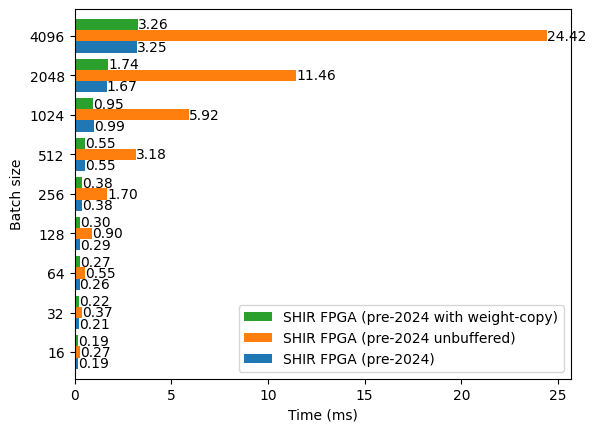

In [16]:
ax = (df_slp_fpga / 1_000_000).plot.barh(width=0.85)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Batch size')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

In [18]:
df_slp_fpga = pd.DataFrame({
    'SHIR FPGA (2024-02-18)': load_medians('server_metrics/simple_slp/shir_fpga_2024_02_18.csv'),
    'SHIR FPGA (pre-2024)': load_medians('server_metrics_old/simple_slp/shir_fpga_buf.csv'),
})

df_slp_fpga

,SHIR FPGA (2024-02-18),SHIR FPGA (pre-2024)
16,199118.0,187292.0
32,240224.5,213492.0
64,297341.5,261894.5
128,351969.0,294456.5
256,481269.0,378453.0
512,723416.0,548730.5
1024,1379879.0,992051.0
2048,2374874.5,1671808.5
4096,4463980.0,3251889.5


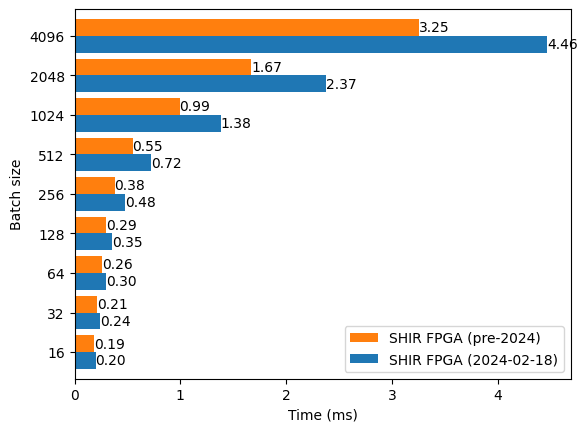

In [19]:
ax = (df_slp_fpga / 1_000_000).plot.barh(width=0.85)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Batch size')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

### Inductor Backend on CPU

To clarify, the quantized configurations properly setup `torch.no_grad()` and `TORCHINDUCTOR_FREEZING` as mentioned in the PT2E report.

In [8]:
df_slp_inductor = pd.DataFrame({
    'SHIR inductor': load_medians('server_metrics/simple_slp/shir_mixed_inductor.csv'),
    'x86 inductor': load_medians('server_metrics/simple_slp/x86_mixed_inductor.csv'),
    'FP32 inductor': load_medians('server_metrics_old/simple_slp/fp32_inductor.csv')
})

df_slp_inductor

,SHIR inductor,x86 inductor,FP32 inductor
16,212432.0,145919.5,68746.5
32,337887.5,195786.0,75930.5
64,684382.5,217607.0,107325.5
128,1339401.0,279081.0,117034.0
256,287853.0,241879.5,147080.5
512,384773.5,254408.0,172733.5
1024,728073.0,322900.0,298528.0
2048,1559214.5,477449.5,399369.5
4096,3630678.5,715249.5,587613.5


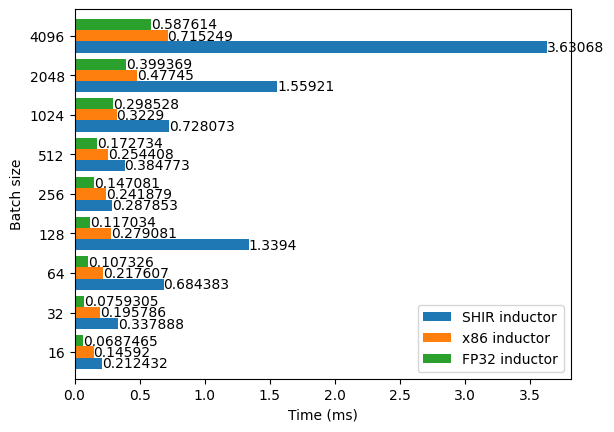

In [9]:
ax = (df_slp_inductor / 1_000_000).plot.barh(width=0.85)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Batch size')
for container in ax.containers:
    ax.bar_label(container)

### Purely Interpreting FX Graph

In [10]:
df_slp_fx = pd.DataFrame({
    'SHIR FX': load_medians('server_metrics_old/simple_slp/shir_fx.csv'),
    'x86 FX': load_medians('server_metrics_old/simple_slp/x86_fx.csv'),
    'FP32 FX': load_medians('server_metrics_old/simple_slp/fp32_fx.csv'),
})

df_slp_fx

,SHIR FX,x86 FX,FP32 FX
16,383867.5,979205.5,52872.0
32,466122.0,1128090.5,60882.5
64,560072.5,1151279.0,96940.0
128,558736.0,1165443.0,105109.0
256,631345.0,1274357.0,126130.0
512,713672.0,1323836.5,146114.5
1024,984935.5,1616294.5,236724.5
2048,4262554.0,4624240.5,388280.0
4096,6452757.5,6686557.5,542530.5


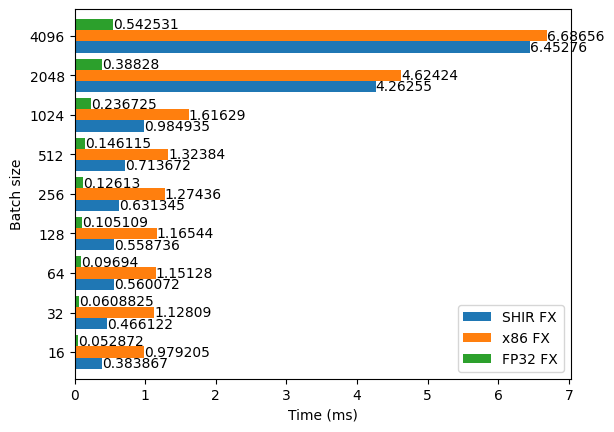

In [11]:
ax = (df_slp_fx / 1_000_000).plot.barh(width=0.85)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Batch size')
for container in ax.containers:
    ax.bar_label(container)

## Dense

In [12]:
# this one is missing b1024 because it doesn't work
df_dense_fpga = pd.read_csv('server_metrics/simple_dense/shir_fpga.csv')
df_dense_fpga.insert(6, 'Missing b1024', 0)
df_dense_fpga.columns = BATCH_SIZES

### TL;DR

In [13]:
df_dense_summary = pd.DataFrame({
    'SHIR FPGA': df_dense_fpga.median(),
    'x86 inductor': load_medians('server_metrics/simple_dense/x86_mixed_inductor.csv'),
    'FP32 eager': load_medians('server_metrics/simple_dense/fp32_eager.csv'),
})

df_dense_summary

,SHIR FPGA,x86 inductor,FP32 eager
16,567746.0,463569.0,234717.0
32,677175.5,415244.5,259204.0
64,870646.0,423744.5,466352.0
128,1292950.0,500534.5,577766.5
256,2067116.5,467851.5,615561.5
512,3553295.5,524891.5,784009.5
1024,0.0,648346.5,1319924.5
2048,13196877.0,1052080.0,2157752.0
4096,25738060.0,2041977.5,5680342.0


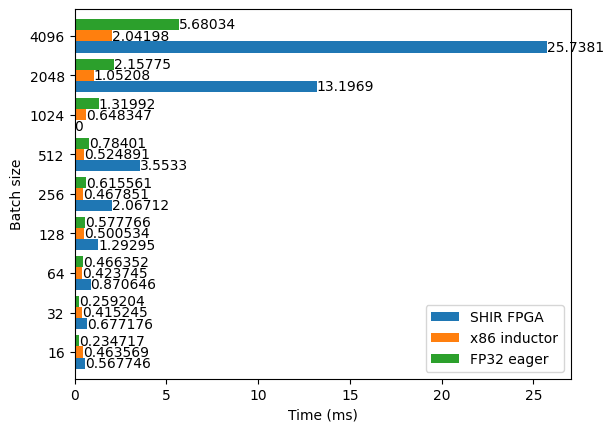

In [14]:
ax = (df_dense_summary / 1_000_000).plot.barh(width=0.85)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Batch size')
for container in ax.containers:
    ax.bar_label(container)